In [1]:
# Useful libraries
%reset -f
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedKFold

from keras.applications.resnet_v2 import ResNet101V2 as BModel, preprocess_input, decode_predictions

In [2]:
IMG_SIZE = (224,224,3)


In [3]:
seed_value= 2022

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)

In [4]:
# Function to read the images
def read_data(img_number_init, img_number_fin):
    # access to folder who contain the image of DOS
    path = 'DOS\\imagesCropees\\'
    # full path : 'C:\Users\Admin\Documents\projet_carcasses_Travail_brouillon\DOS\imagesCropees\' 'image' '2' '.jpg'
    img = path + 'image'+str(img_number_init)+'.jpg'
    img = image.load_img(img, target_size=IMG_SIZE)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    
    for i in range(img_number_init+1,img_number_fin+1):
        img = path+'image'+str(i)+'.jpg'
        img = image.load_img(img, target_size=IMG_SIZE)
        xx = image.img_to_array(img)
        xx = np.expand_dims(xx, axis=0)
        x = np.vstack([x, xx])
        
    return x

In [5]:
# Cleaning data
img_removed = [23, 43, 113, 153, 170, 187, 222, 230, 289, 316, 350, 395, 429, 483, 518, 541, 556, 566, 577, 652]
# NB : we need to remove the date cause "misunderstand" for the training procedures.
# Read data
nbr = len(img_removed)

X = read_data(3, img_removed[0]-1)

for i in range(nbr-1):
    X = np.vstack([X, read_data(img_removed[i]+1, img_removed[i+1]-1)])

# Normalize inputs
X = X/255
df = pd.read_excel ('classification.xlsx', engine='openpyxl')
# transform categorical to numeric
df['Conf'].replace(['U','R','O','P'],[0, 1, 2, 3], inplace=True)

In [6]:
y_all = df['Conf']
y_all = np.array(y_all)

y = y_all[1:img_removed[0]-1]

for i in range(nbr-1):
    y = np.hstack([y, y_all[img_removed[i]:img_removed[i+1]-1]])
    

In [7]:
# Separation of data in train-validation-test with rate of 60%-20%-20%
from sklearn.model_selection import train_test_split

X = preprocess_input(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=2)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=2)

In [8]:
def create_model():
    
    # load the convolutional base model and set layers as not trainable
    
    base_model = tf.keras.applications.ResNet101V2(input_shape=IMG_SIZE, include_top=False)

    for layer in base_model.layers:
        layer.trainable = False


    # add new classifier layers

    x = keras.layers.Flatten()(base_model.layers[-1].output)
    x = keras.layers.BatchNormalization()(x)

    x = layers.Dense(128, activation='elu', kernel_initializer='he_normal')(x)
    x = layers.Dropout(0.6)(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Dense(64, activation='elu', kernel_initializer='he_normal')(x)
    x = layers.Dropout(0.6)(x)
    x = layers.BatchNormalization()(x)
    

    output = layers.Dense(4, activation='softmax')(x)

    # define new model, compile and fit
    model = tensorflow.keras.Model(inputs=base_model.inputs, outputs=output)
    

    
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [9]:
# store the trained models in a list

callbacks = [
    EarlyStopping(monitor = "val_accuracy",patience = 20),
    ModelCheckpoint(
    filepath = 'pretrain_RESNET101V2',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)
]

model = create_model()



In [10]:
len(model.layers)

386

In [11]:
# Trains the model
history=model.fit(X_train,y_train,epochs=100, batch_size = 64,
               callbacks=callbacks,
               validation_data = (X_val,y_val))
print('*************************')
print('Training next model')
print('*************************')

Epoch 1/100
6/6 [==============================] - 22s 2s/step - loss: 1.9982 - accuracy: 0.2513 - val_loss: 5.2965 - val_accuracy: 0.4127

Epoch 00001: val_accuracy improved from -inf to 0.41270, saving model to pretrain_RESNET101V2


C:\Users\tnngo1\Anaconda3\envs\GPU\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: pretrain_RESNET101V2\assets
Epoch 2/100
6/6 [==============================] - 2s 352ms/step - loss: 1.5982 - accuracy: 0.3545 - val_loss: 5.6521 - val_accuracy: 0.4127

Epoch 00002: val_accuracy did not improve from 0.41270
Epoch 3/100
6/6 [==============================] - 2s 401ms/step - loss: 1.5005 - accuracy: 0.3862 - val_loss: 5.1313 - val_accuracy: 0.4127

Epoch 00003: val_accuracy did not improve from 0.41270
Epoch 4/100
6/6 [==============================] - 2s 411ms/step - loss: 1.4821 - accuracy: 0.3836 - val_loss: 4.4732 - val_accuracy: 0.4127

Epoch 00004: val_accuracy did not improve from 0.41270
Epoch 5/100
6/6 [==============================] - 2s 411ms/step - loss: 1.3747 - accuracy: 0.4180 - val_loss: 3.3532 - val_accuracy: 0.4127

Epoch 00005: val_accuracy did not improve from 0.41270
Epoch 6/100
6/6 [==============================] - 2s 413ms/step - loss: 1.2525 - accuracy: 0.4683 - val_loss: 3.1235 - val_accuracy: 0.4127

Epoch 0

C:\Users\tnngo1\Anaconda3\envs\GPU\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: pretrain_RESNET101V2\assets
Epoch 20/100
6/6 [==============================] - 2s 357ms/step - loss: 0.6892 - accuracy: 0.7540 - val_loss: 2.6061 - val_accuracy: 0.4286

Epoch 00020: val_accuracy did not improve from 0.42857
Epoch 21/100
6/6 [==============================] - 2s 366ms/step - loss: 0.5532 - accuracy: 0.8228 - val_loss: 2.2163 - val_accuracy: 0.4286

Epoch 00021: val_accuracy did not improve from 0.42857
Epoch 22/100
6/6 [==============================] - 2s 417ms/step - loss: 0.5385 - accuracy: 0.8148 - val_loss: 2.0205 - val_accuracy: 0.4286

Epoch 00022: val_accuracy did not improve from 0.42857
Epoch 23/100
6/6 [==============================] - 2s 420ms/step - loss: 0.5079 - accuracy: 0.8228 - val_loss: 1.9933 - val_accuracy: 0.4286

Epoch 00023: val_accuracy did not improve from 0.42857
Epoch 24/100
6/6 [==============================] - 2s 417ms/step - loss: 0.4558 - accuracy: 0.8386 - val_loss: 1.7245 - val_accuracy: 0.4444

Ep

C:\Users\tnngo1\Anaconda3\envs\GPU\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: pretrain_RESNET101V2\assets
Epoch 25/100
6/6 [==============================] - 2s 363ms/step - loss: 0.4240 - accuracy: 0.8545 - val_loss: 1.8565 - val_accuracy: 0.4444

Epoch 00025: val_accuracy did not improve from 0.44444
Epoch 26/100
6/6 [==============================] - 2s 415ms/step - loss: 0.3637 - accuracy: 0.8915 - val_loss: 2.0597 - val_accuracy: 0.4286

Epoch 00026: val_accuracy did not improve from 0.44444
Epoch 27/100
6/6 [==============================] - 2s 418ms/step - loss: 0.3997 - accuracy: 0.8519 - val_loss: 1.8205 - val_accuracy: 0.4524

Epoch 00027: val_accuracy improved from 0.44444 to 0.45238, saving model to pretrain_RESNET101V2


C:\Users\tnngo1\Anaconda3\envs\GPU\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: pretrain_RESNET101V2\assets
Epoch 28/100
6/6 [==============================] - 2s 347ms/step - loss: 0.3218 - accuracy: 0.8862 - val_loss: 1.8420 - val_accuracy: 0.4524

Epoch 00028: val_accuracy did not improve from 0.45238
Epoch 29/100
6/6 [==============================] - 2s 390ms/step - loss: 0.3666 - accuracy: 0.8836 - val_loss: 1.6792 - val_accuracy: 0.4524

Epoch 00029: val_accuracy did not improve from 0.45238
Epoch 30/100
6/6 [==============================] - 2s 408ms/step - loss: 0.3246 - accuracy: 0.9074 - val_loss: 1.4896 - val_accuracy: 0.4841

Epoch 00030: val_accuracy improved from 0.45238 to 0.48413, saving model to pretrain_RESNET101V2


C:\Users\tnngo1\Anaconda3\envs\GPU\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: pretrain_RESNET101V2\assets
Epoch 31/100
6/6 [==============================] - 2s 360ms/step - loss: 0.2743 - accuracy: 0.9233 - val_loss: 1.5366 - val_accuracy: 0.4921

Epoch 00031: val_accuracy improved from 0.48413 to 0.49206, saving model to pretrain_RESNET101V2


C:\Users\tnngo1\Anaconda3\envs\GPU\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: pretrain_RESNET101V2\assets
Epoch 32/100
6/6 [==============================] - 2s 381ms/step - loss: 0.2880 - accuracy: 0.9127 - val_loss: 1.4274 - val_accuracy: 0.5238

Epoch 00032: val_accuracy improved from 0.49206 to 0.52381, saving model to pretrain_RESNET101V2


C:\Users\tnngo1\Anaconda3\envs\GPU\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: pretrain_RESNET101V2\assets
Epoch 33/100
6/6 [==============================] - 2s 399ms/step - loss: 0.2880 - accuracy: 0.9074 - val_loss: 1.6995 - val_accuracy: 0.4762

Epoch 00033: val_accuracy did not improve from 0.52381
Epoch 34/100
6/6 [==============================] - 2s 417ms/step - loss: 0.2739 - accuracy: 0.9180 - val_loss: 1.7157 - val_accuracy: 0.5000

Epoch 00034: val_accuracy did not improve from 0.52381
Epoch 35/100
6/6 [==============================] - 2s 413ms/step - loss: 0.2494 - accuracy: 0.9206 - val_loss: 1.6539 - val_accuracy: 0.5079

Epoch 00035: val_accuracy did not improve from 0.52381
Epoch 36/100
6/6 [==============================] - 2s 409ms/step - loss: 0.2398 - accuracy: 0.9365 - val_loss: 1.5049 - val_accuracy: 0.5476

Epoch 00036: val_accuracy improved from 0.52381 to 0.54762, saving model to pretrain_RESNET101V2


C:\Users\tnngo1\Anaconda3\envs\GPU\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: pretrain_RESNET101V2\assets
Epoch 37/100
6/6 [==============================] - 2s 348ms/step - loss: 0.2344 - accuracy: 0.9365 - val_loss: 1.4859 - val_accuracy: 0.5556

Epoch 00037: val_accuracy improved from 0.54762 to 0.55556, saving model to pretrain_RESNET101V2


C:\Users\tnngo1\Anaconda3\envs\GPU\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: pretrain_RESNET101V2\assets
Epoch 38/100
6/6 [==============================] - 2s 357ms/step - loss: 0.2115 - accuracy: 0.9497 - val_loss: 1.3694 - val_accuracy: 0.5714

Epoch 00038: val_accuracy improved from 0.55556 to 0.57143, saving model to pretrain_RESNET101V2


C:\Users\tnngo1\Anaconda3\envs\GPU\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: pretrain_RESNET101V2\assets
Epoch 39/100
6/6 [==============================] - 2s 355ms/step - loss: 0.1981 - accuracy: 0.9471 - val_loss: 1.4158 - val_accuracy: 0.5952

Epoch 00039: val_accuracy improved from 0.57143 to 0.59524, saving model to pretrain_RESNET101V2


C:\Users\tnngo1\Anaconda3\envs\GPU\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: pretrain_RESNET101V2\assets
Epoch 40/100
6/6 [==============================] - 2s 383ms/step - loss: 0.2378 - accuracy: 0.9286 - val_loss: 1.3740 - val_accuracy: 0.5952

Epoch 00040: val_accuracy did not improve from 0.59524
Epoch 41/100
6/6 [==============================] - 2s 417ms/step - loss: 0.1987 - accuracy: 0.9444 - val_loss: 1.2606 - val_accuracy: 0.6032

Epoch 00041: val_accuracy improved from 0.59524 to 0.60317, saving model to pretrain_RESNET101V2


C:\Users\tnngo1\Anaconda3\envs\GPU\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: pretrain_RESNET101V2\assets
Epoch 42/100
6/6 [==============================] - 2s 370ms/step - loss: 0.1718 - accuracy: 0.9550 - val_loss: 1.2885 - val_accuracy: 0.5873

Epoch 00042: val_accuracy did not improve from 0.60317
Epoch 43/100
6/6 [==============================] - 2s 418ms/step - loss: 0.1851 - accuracy: 0.9365 - val_loss: 1.5926 - val_accuracy: 0.5397

Epoch 00043: val_accuracy did not improve from 0.60317
Epoch 44/100
6/6 [==============================] - 2s 418ms/step - loss: 0.1816 - accuracy: 0.9471 - val_loss: 1.4738 - val_accuracy: 0.5794

Epoch 00044: val_accuracy did not improve from 0.60317
Epoch 45/100
6/6 [==============================] - 2s 424ms/step - loss: 0.1780 - accuracy: 0.9418 - val_loss: 1.2789 - val_accuracy: 0.5952

Epoch 00045: val_accuracy did not improve from 0.60317
Epoch 46/100
6/6 [==============================] - 2s 410ms/step - loss: 0.1740 - accuracy: 0.9392 - val_loss: 1.4244 - val_accuracy: 0.5873

Ep

C:\Users\tnngo1\Anaconda3\envs\GPU\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: pretrain_RESNET101V2\assets
Epoch 51/100
6/6 [==============================] - 3s 397ms/step - loss: 0.1246 - accuracy: 0.9683 - val_loss: 1.1785 - val_accuracy: 0.6667

Epoch 00051: val_accuracy improved from 0.61111 to 0.66667, saving model to pretrain_RESNET101V2


C:\Users\tnngo1\Anaconda3\envs\GPU\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: pretrain_RESNET101V2\assets
Epoch 52/100
6/6 [==============================] - 2s 364ms/step - loss: 0.1319 - accuracy: 0.9683 - val_loss: 1.2458 - val_accuracy: 0.6270

Epoch 00052: val_accuracy did not improve from 0.66667
Epoch 53/100
6/6 [==============================] - 2s 411ms/step - loss: 0.1016 - accuracy: 0.9788 - val_loss: 1.2511 - val_accuracy: 0.6111

Epoch 00053: val_accuracy did not improve from 0.66667
Epoch 54/100
6/6 [==============================] - 2s 414ms/step - loss: 0.1160 - accuracy: 0.9656 - val_loss: 1.2984 - val_accuracy: 0.6190

Epoch 00054: val_accuracy did not improve from 0.66667
Epoch 55/100
6/6 [==============================] - 2s 416ms/step - loss: 0.0815 - accuracy: 0.9868 - val_loss: 1.3766 - val_accuracy: 0.6190

Epoch 00055: val_accuracy did not improve from 0.66667
Epoch 56/100
6/6 [==============================] - 2s 417ms/step - loss: 0.1305 - accuracy: 0.9603 - val_loss: 1.3314 - val_accuracy: 0.6349

Ep

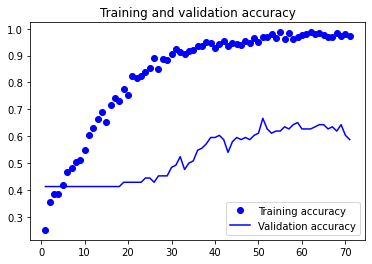

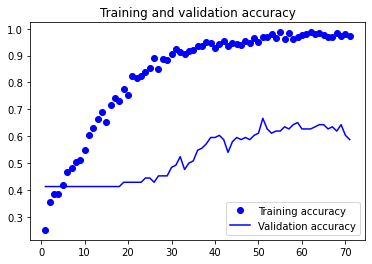

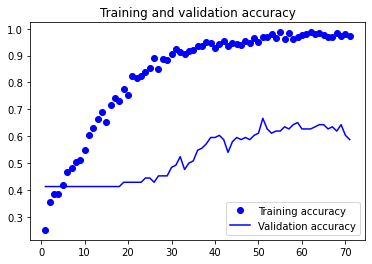

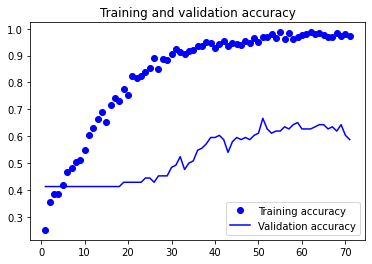

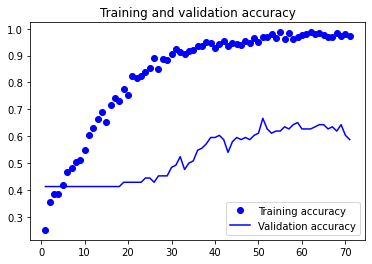

In [12]:
# Displaying curves of loss and accuracy during training

for i in range(5):
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, "bo", label="Training accuracy")
    plt.plot(epochs, val_acc, "b", label="Validation accuracy")
    plt.title("Training and validation accuracy")
    plt.legend()
    plt.show()

In [13]:
model.evaluate(X_test,y_test)

4/4 [==============================] - 4s 786ms/step - loss: 1.2888 - accuracy: 0.7063


[1.2887567281723022, 0.7063491940498352]